<a href="https://colab.research.google.com/github/andy-j-block/lymphoma_classifier/blob/master/Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TODO:

- continue tinkering with data generation
    - transforms for the validation set as well?
- build custom model?
- train models
- fix inception input vs kernel size mismatch

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/andy-j-block/lymphoma_classifier/blob/master/Classifier.ipynb)

# Setup and Data Import

In [1]:
from PIL import Image
import os
from matplotlib import pyplot as plt
from os.path import abspath
import numpy as np
import pandas as pd
import random
import gc

In [2]:
def running_hosted():

    if 'content' in os.getcwd():
        hosted = True
      
    else:
        hosted = False
        %autosave 120
    
    if hosted:
       print(f'This notebook is running hosted') 
    
    else:
        print(f'This notebook is running locally\nAutosave is set to 120 seconds')

    return hosted

############

def colab_setup():

    %cd -q /content/
    
    #check if git clone already performed
    if not os.path.isdir('./lymphoma_classifier'):
        !git clone https://github.com/andy-j-block/lymphoma_classifier.git
        
    %cd -q /content/lymphoma_classifier
    current_dir = os.getcwd()
    print(f"Current directory is '{current_dir}'")


############      

def load_images(imgs_main_dir):
    
    # get cancer type strings
    cancer_types = [type_ for type_ in os.listdir(imgs_main_dir)]

    # get directories where images are stored
    img_dirs = [os.path.join(imgs_main_dir, type_) for type_ in cancer_types]
    
    # read images into a list
    imgs = []

    for i, img_dir in enumerate(img_dirs):       
        img_paths = os.listdir(img_dir)
        
        for j in img_paths:

            # pass thru all the image files per image directory, read the image,
            # add it to the images list
            img_path = os.path.join(img_dirs[i], j)
            img_array = Image.open(img_path)
            img_array = np.asarray(img_array)        
            imgs.append((cancer_types[i], img_array))
                
    return imgs

###Local or hosted runtime

I like to use Google Colab for its hosted runtime features so I include a check to see if the notebook is being run locally or hosted.

In [3]:
hosted = running_hosted()

This notebook is running hosted


In [4]:
if hosted:
    colab_setup()

Cloning into 'lymphoma_classifier'...
remote: Enumerating objects: 511, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 511 (delta 48), reused 3 (delta 1), pack-reused 416
Receiving objects: 100% (511/511), 1.41 GiB | 14.71 MiB/s, done.
Resolving deltas: 100% (65/65), done.
Checking out files: 100% (380/380), done.
Current directory is '/content/lymphoma_classifier'


Fetching the latest version of albumentations library if running on hosted machine

In [5]:
if hosted:
    !pip install albumentations --upgrade

     |████████████████████████████████| 81kB 5.4MB/s 
     |████████████████████████████████| 952kB 10.4MB/s 
     |████████████████████████████████| 37.6MB 67kB/s 
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


###Data import and image preview

Import the images and store them in a data structure

In [6]:
imgs = load_images('./Images')

First entry cancer type: MCL
First entry RGB array: [[[163 144 147]
  [164 144 150]
  [151 129 140]
  ...
  [ 97  80 106]
  [ 89  70  98]
  [ 81  62  92]]

 [[163 144 152]
  [160 144 155]
  [144 129 144]
  ...
  [ 97  80 105]
  [ 88  70  98]
  [ 78  62  92]]

 [[150 133 150]
  [146 133 152]
  [127 111 133]
  ...
  [ 97  78 103]
  [ 88  68  98]
  [ 77  59  91]]

 ...

 [[188 160 165]
  [192 160 162]
  [197 162 165]
  ...
  [197 185 182]
  [198 183 179]
  [198 179 179]]

 [[184 147 156]
  [184 147 155]
  [185 144 152]
  ...
  [201 187 186]
  [198 183 180]
  [195 182 180]]

 [[184 140 151]
  [174 140 151]
  [172 133 146]
  ...
  [200 185 186]
  [199 183 183]
  [201 183 178]]]
First entry image:


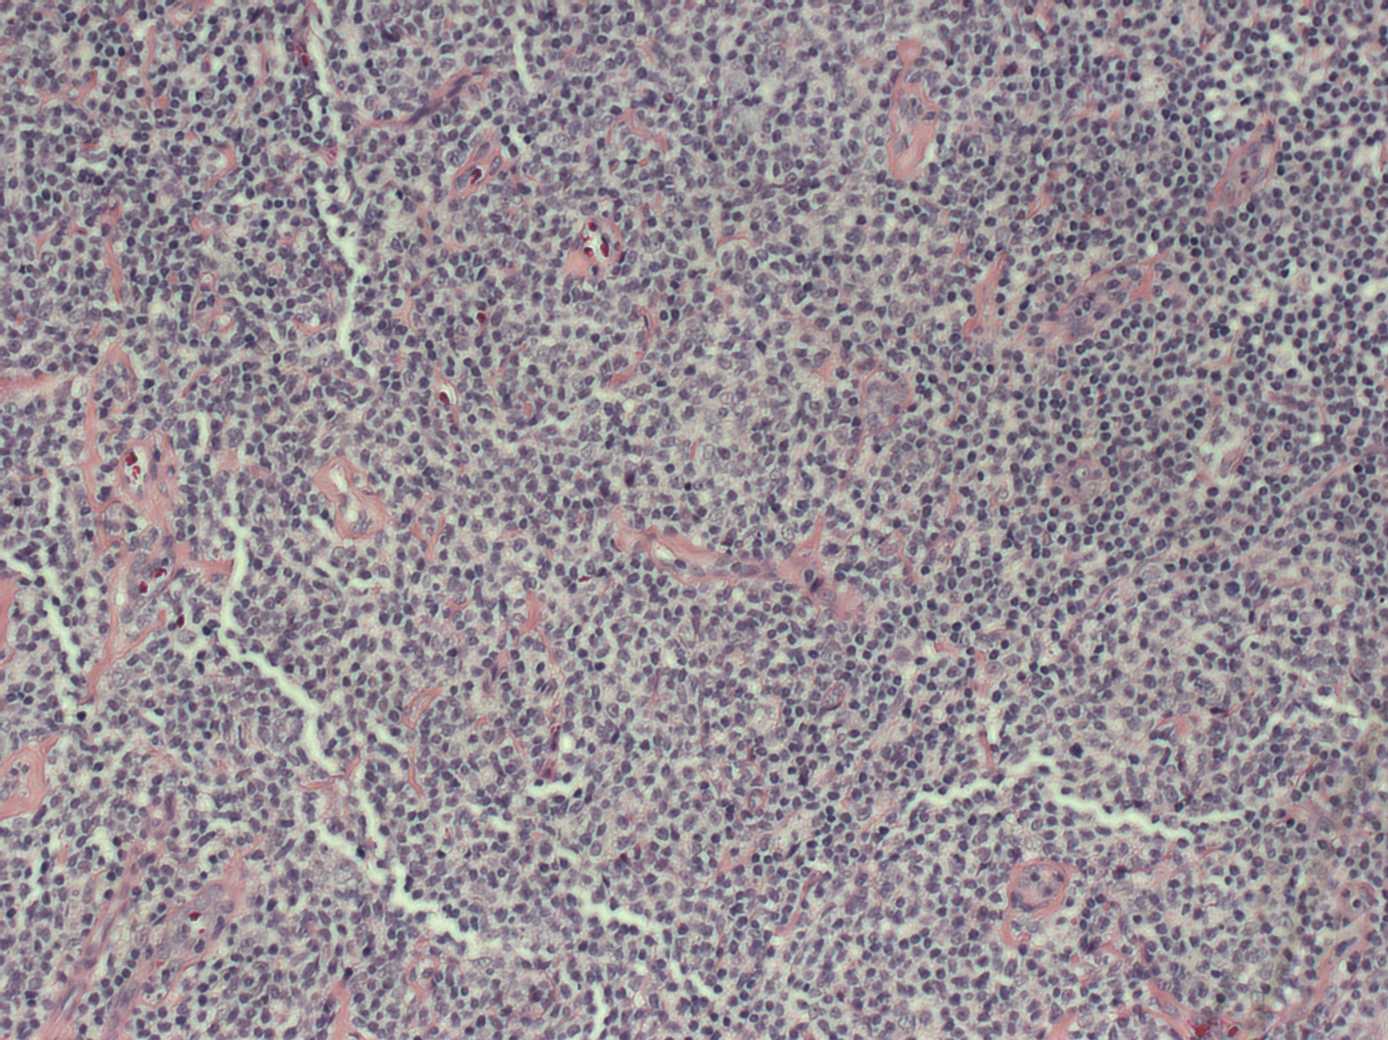

In [7]:
print(f'First entry cancer type: {imgs[0][0]}')
print(f'First entry RGB array: {imgs[0][1]}')
print('First entry image:')
Image.fromarray(imgs[0][1])

###Create DataFrame

In [8]:
df = pd.DataFrame(imgs, columns=['cancer_type', 'img_array'])
df.head(3)

cancer_type                                          img_array
0         MCL  [[[163, 144, 147], [164, 144, 150], [151, 129,...
1         MCL  [[[163, 150, 156], [163, 150, 159], [156, 153,...
2         MCL  [[[176, 133, 139], [173, 133, 138], [171, 134,...

# Exploratory Data Analysis

In [9]:
import pandas as pd
import torch
import matplotlib.pyplot as plt

In [10]:
def show_value_counts(series):

    print(f'The value counts are:\n{series.value_counts()}')

    percentages = [i/len(df) for i in series.value_counts().values]
    percentages = [round(i,2) for i in percentages]

    fig, ax = plt.subplots(1,1,figsize=(10,5))

    bar_chart=ax.bar(x=series.value_counts().index, 
                    height=series.value_counts().values)

    # Grabbed from matplotlib documentation:
    # https://matplotlib.org/2.0.2/examples/api/barchart_demo.html
    def autolabel(bar_chart, text_labels):
        for i, bar in enumerate(bar_chart):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    text_labels[i],
                    ha='center', va='bottom')# rotation=0?)
            
    autolabel(bar_chart, percentages)

    plt.title('Count by cancer type with percentages as text')
    plt.show()

############

def get_image_dims(data, set_=True):

    img_heights = []
    img_widths = []

    # widths and heights if input is pandas series 
    if type(data) is pd.Series:

        for i, _ in enumerate(data):
            img = data.iloc[i]
            height, width = img.shape[0], img.shape[1]
            img_heights.append(height)
            img_widths.append(width)

        if set_:
            # cast to set to eliminate duplicates
            img_heights = set(img_heights)
            img_widths = set(img_widths)
                
            print('Image heights are: ', img_heights)
            print('Image widths are: ', img_widths)
    
    # widths and heights if input is torchvision dataset
    else:

        for i in range(len(data)):
            width, height = data[i][0].shape[2], data[i][0].shape[1]
            img_heights.append(height)
            img_widths.append(width)

        # cast to set to eliminate duplicates
        img_heights = set(img_heights)
        img_widths = set(img_widths)
            
        print('Image heights are: ', img_heights)
        print('Image widths are: ', img_widths)

    if not set_:
        img_heights = min(img_heights)
        img_widths = min(img_widths)

    return img_heights, img_widths

############

def get_intensity_range(data):

    maxs = []
    mins = []

    # intesities if input is pandas series
    if type(data) is pd.Series:

        for i, _ in enumerate(data):
            maxs.append(np.amax(data.values[i]))
            mins.append(np.amin(data.values[i]))

    # intensities if input is torchvision dataset
    else:

        for i in range(len(data)):
            maxs.append(torch.max(data[i][0]))
            mins.append(torch.min(data[i][0])) 

    print(f'The highest intesity in the range: {max(maxs)}')
    print(f'The lowest intesity in the range: {min(mins)}')

############

def get_random_image(data, decode_dict, figsize=(30,10)):

    rand_imgs = []
    rand_idxs = []

    if type(data) is pd.DataFrame:
        for i in range(3):
            data_by_type = data[data['cancer_type']==i]
            rand_img = random.choice(data_by_type['img_array'].values)
            rand_imgs.append(rand_img)

        fig, axs = plt.subplots(1, len(rand_imgs), figsize=figsize)

        for i, img in enumerate(rand_imgs):
            axs[i].set_title(f'Cancer type: {decode_dict[i]}')
            axs[i].imshow(img)

    else:

        for _ in range(4):
            
            # get random index and store for later
            data_idxs = range(len(data))
            rand_idx = random.choice(data_idxs)
            rand_idxs.append(rand_idx)
            
            # get image with random index and convert RGB array back to image
            rand_img = data[rand_idx][0]
            rand_img = rand_img.permute(1, 2, 0)
            rand_imgs.append(rand_img)

        fig, axs = plt.subplots(1, 4, figsize=figsize)

        for i, img in enumerate(rand_imgs):
            axs[i].set_title(f'Cancer type: {decode_dict[int(data[rand_idxs[i]][1])]}')
            axs[i].imshow(img)

###Class distribution

The value counts are:
FL     139
MCL    122
CLL    113
Name: cancer_type, dtype: int64


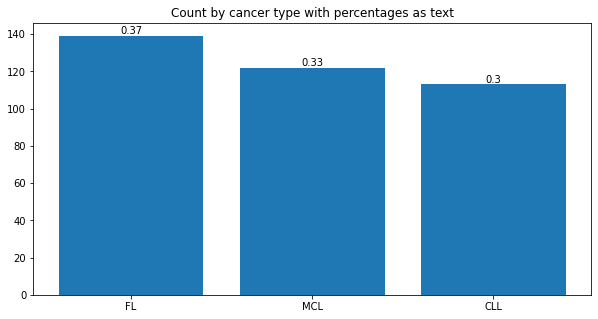

In [11]:
show_value_counts(df['cancer_type'])

###Label Encoding

PyTorch needs the labels to be numerically encoded in order to incorporate them in the dataloader.

In [12]:
encode_dict = {'CLL':0, 'FL':1, 'MCL':2}
decode_dict = {0: 'CLL', 1: 'FL', 2: 'MCL'}
df['cancer_type']=df['cancer_type'].replace(encode_dict)
df['cancer_type'].value_counts()

1    139
2    122
0    113
Name: cancer_type, dtype: int64

###Image size and color intensity

In [13]:
img_heights, img_widths = get_image_dims(df['img_array'])
img_heights_int, img_widths_int = get_image_dims(df['img_array'], set_=False)

Image heights are:  {1040}
Image widths are:  {1388}


Single value sets mean all images with the same height and width.  Let's confirm the pixel color intensity range

In [14]:
get_intensity_range(df['img_array'])

The highest intesity in the range: 255
The lowest intesity in the range: 2


I think it's safe to say that these RGB color values range from (0,255).  Color scaling later on will reflect this range

###Sample images

Let's look at a random image of each cancer type.

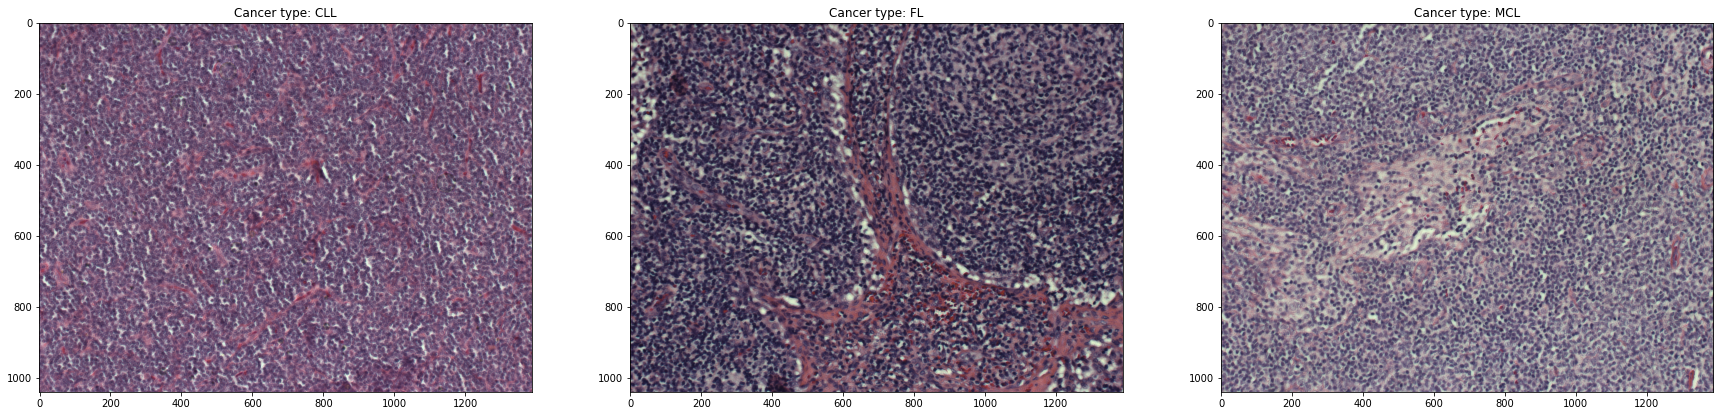

In [15]:
get_random_image(df, decode_dict)

# Prepare Data

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
def visualize_sets(full_series, train_series, test_series, titles):

    series = [full_series, train_series, test_series]

    percentages = []
    
    for i, series_ in enumerate(series):

        percentage = [j/len(series_) for j in series_.value_counts().values]
        percentage = [round(j,2) for j in percentage]
        percentages.append(percentage)

    fig, ax = plt.subplots(1,len(series),figsize=(20,5))

    dfs=[]

    for i, series_ in enumerate(series):

        df = ax[i].bar(x=series_.value_counts().index, 
                    height=series_.value_counts().values)
        
        dfs.append(df)

    # Grabbed from matplotlib documentation:
    # https://matplotlib.org/2.0.2/examples/api/barchart_demo.html
    def autolabel(bar_charts, text_labels):
        for i, chart in enumerate(bar_charts):
            for j, bar in enumerate(chart):
                height = bar.get_height()
                ax[i].text(bar.get_x() + bar.get_width()/2., height,
                        text_labels[i][j],
                        ha='center', va='bottom')# rotation=0?)
            
    autolabel(dfs, percentages)

    for i, title in enumerate(titles):
        ax[i].set_title(title)
    
    plt.show()

###Train test split

We want to create a holdout test set now, but we don't want to split the target variable yet from the image and its path.  When we move onto data generation, we need to keep the target available, so we will just separate the dataframe as a whole.

In [18]:
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['cancer_type'], random_state=42) 

In [19]:
print(df_train.shape, df_test.shape)

(299, 2) (75, 2)


Store the training and validation data before splitting for later use in normalization transforms

In [20]:
df_train_and_val = df_train.copy()

###Set visualizing

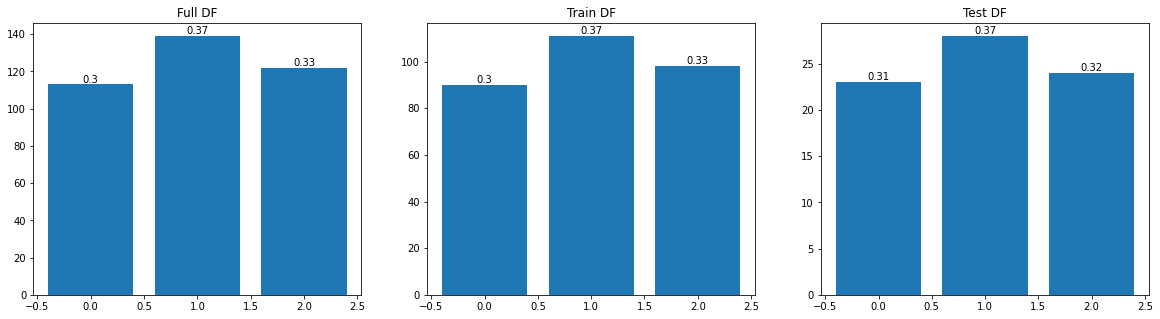

In [21]:
visualize_sets(df['cancer_type'], df_train['cancer_type'], df_test['cancer_type'], ['Full DF', 'Train DF', 'Test DF'])

In [22]:
df_test.head(3)

cancer_type                                          img_array
30             2  [[[118, 113, 127], [113, 113, 125], [110, 103,...
221            0  [[[105, 72, 108], [98, 72, 107], [80, 64, 98],...
98             2  [[[38, 37, 50], [43, 37, 52], [57, 40, 61], [6...

Let's just reset the index here for clarity.

In [23]:
df_test.reset_index(inplace=True, drop=True)
df_test.head(3)

cancer_type                                          img_array
0            2  [[[118, 113, 127], [113, 113, 125], [110, 103,...
1            0  [[[105, 72, 108], [98, 72, 107], [80, 64, 98],...
2            2  [[[38, 37, 50], [43, 37, 52], [57, 40, 61], [6...

In [24]:
df_test['cancer_type'].value_counts()

1    28
2    24
0    23
Name: cancer_type, dtype: int64

###Train val split

The data needs to be split again before generation can occur, that was the validation set generated data doesn't get into the training set.

In [25]:
df_train, df_valid = train_test_split(df_train, test_size=0.2, random_state=42)

In [26]:
df_train.head(3)

cancer_type                                          img_array
247            1  [[[93, 57, 89], [104, 57, 88], [107, 56, 87], ...
210            0  [[[133, 116, 128], [130, 116, 131], [126, 103,...
107            2  [[[141, 98, 122], [151, 98, 117], [169, 119, 1...

Again, let's reset our indices.

In [27]:
df_train.reset_index(inplace=True, drop=True)
df_valid.reset_index(inplace=True, drop=True)

# Data Generation

In [28]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms

###Device detection

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
torch.backends.cudnn.benchmark = True

cuda


###Dataset and dataloader

Albumentations library

In [30]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

Define dataset class for dataloader to call

In [31]:
class lymphoma_images_dataset(Dataset):

    def __init__(self, type_, imgs, transform=None):
        self.type_ = type_
        self.imgs = imgs
        self.transform = transform
      
    def __len__(self):
        return len(self.type_)
    
    def __getitem__(self, idx):
        
        img = self.imgs.iloc[idx]
        label = torch.tensor(int(self.type_.iloc[idx]))

        if self.transform:
            img = self.transform(img)

        return (img, label)

############

def define_dataset(type_series, image_series, transform=None, batch_size=4, shuffle=True, num_workers=2):

    data = lymphoma_images_dataset(type_series, image_series, transform=transform)
    loader = DataLoader(data, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

    return data, loader


############

def create_data(num_passes, transforms, phase, orig_df):

    new_df = orig_df.copy()
    orig_df_len = len(orig_df)
    cols = new_df.columns

    # generate new data
    for i in range(num_passes):

        for j in range(len(orig_df)):

            # perform transformations
            new_array = transforms[phase](image=orig_df['img_array'].values[j])
            new_array = transforms['normalize_resize'](image=new_array['image'])
            new_array = new_array['image']

            new_data = {cols[0]:orig_df[cols[0]].iloc[j],
                        cols[1]:new_array,
                        }

            new_df = new_df.append(new_data, ignore_index=True)

    # normalize original data
    for i in range(orig_df_len):
        new_array = transforms['normalize_resize'](image=new_df['img_array'].values[i])
        new_df.at[i, 'img_array'] = new_array['image']
    
    return new_df


Set useful constants

In [32]:
p = 0.4

tl_means = (0.485, 0.456, 0.406)
tl_stds = (0.229, 0.224, 0.225)

resize_factor = img_widths_int/4

In [33]:
#LongestMaxSize interpolation strategy?
#validation transformations?

alb_transform_dict = {'train': A.Compose([A.HorizontalFlip(p=p),
                                          A.VerticalFlip(p=p),
                                          A.ColorJitter(p=p),
                                          A.Rotate(limit=10, interpolation=cv2.BORDER_CONSTANT, p=p),
                                          A.RGBShift(p=p)
                                          ]),
                      
                      'valid': A.Compose([A.HorizontalFlip(p=p),
                                          A.VerticalFlip(p=p),
                                          A.ColorJitter(p=p),                                          
                                          A.Rotate(limit=10, interpolation=cv2.BORDER_CONSTANT, p=p),
                                          A.RGBShift(p=p)
                                          ]),
                      
                      'normalize_resize': A.Compose([A.Normalize(mean=tl_means, std=tl_stds),
                                                     A.LongestMaxSize(resize_factor)
                                                     ]),
                      }


In [34]:
df_train_aug = create_data(4, alb_transform_dict, 'train', df_train)
df_valid_aug = create_data(4, alb_transform_dict, 'valid', df_valid)

In [35]:
print(df_train_aug.head(2), '\n', df_train_aug.tail(2))
print(df_valid_aug.head(2), '\n', df_valid_aug.tail(2))

   cancer_type                                          img_array
0            1  [[[-0.17424442, -0.9502801, -0.19224398], [-0....
1            0  [[[0.108314015, -0.083683446, 0.5005665], [-0.... 
       cancer_type                                          img_array
1193            1  [[[-0.62376916, -0.7139355, 0.28705883], [-0.3...
1194            0  [[[0.9003339, 0.7303921, 0.96679735], [1.00736...
   cancer_type                                          img_array
0            1  [[[-0.7136742, -0.70518196, 0.01690634], [-0.3...
1            0  [[[-0.37546027, -0.37254897, 0.45699346], [0.3... 
      cancer_type                                          img_array
298            1  [[[0.16396946, -0.5563725, -0.08766882], [0.03...
299            2  [[[-0.27699292, -0.7533263, -0.017952047], [0....


Dataloader

In [36]:
train_data_8batch, train_loader_8batch = define_dataset(df_train_aug['cancer_type'], df_train_aug['img_array'], batch_size=8, transform=transforms.ToTensor())
valid_data_8batch, valid_loader_8batch = define_dataset(df_valid_aug['cancer_type'], df_valid_aug['img_array'], batch_size=8, transform=transforms.ToTensor())

datasets = {
            'train': train_data_8batch,
            'valid': valid_data_8batch
            }
dataloaders = {
               'train': train_loader_8batch,
               'valid': valid_loader_8batch
              }

###Confirm image dimensions and intensities

In [37]:
img_heights, img_widths = get_image_dims(train_data_8batch)

Image heights are:  {260}
Image widths are:  {347}


In [38]:
get_intensity_range(train_data_8batch)

The highest intesity in the range: 2.6399998664855957
The lowest intesity in the range: -2.1179039478302


###Visualize some generated data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


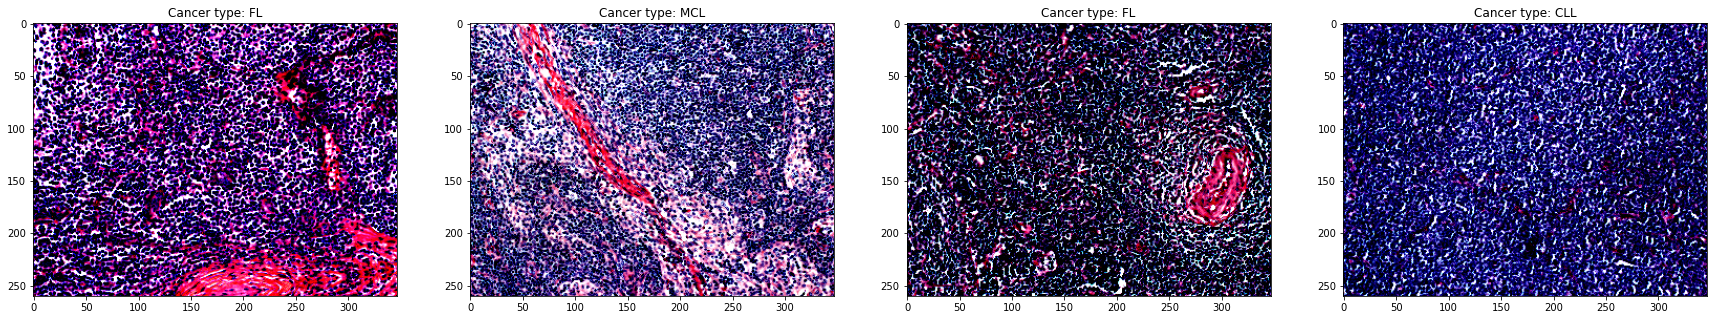

In [39]:
get_random_image(train_data_8batch, decode_dict)


# Model Build

In [40]:
import torch.nn as nn
import torch.functional as F
import torch.optim as optim

###Bespoke model architectures

In [41]:
class shallow_net(nn.Module):
    # this network will consist of three CRB layers before a fully connected

    def __init__(self):
        super(shallow_net, self).__init__()

        self.conv1_k5 = nn.Conv2d(3, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        # initialize weights?? nn.init.kaiming_uniform_, nn.init.xavier_uniform_
        self.ap = nn.AvgPool2d(2)
        self.fc = nn.Linear(1408, 3)

    
    def forward(self, x):
        x = F.relu(self.ap(self.conv1(x)))
        x = x.view(-1)
        x = self.fc(x)
        return F.log_softmax(x)

class medium_net(shallow_net):
     # this network will consist of five CRB layers before a fully connected
    pass

class deep_net(nn.Module):
    # this network will consist of eight CRB layers before a fully connected
    pass

class very_deep_net(nn.Module):
    # this network will consist of twelve CRB layers before a fully connected
    pass

    # def __init__(self, in_channels):
    #     super(Net, self).__init__()

    #     self.branch1x1 = nn.Conv2d(in_channels, 16, kernel_size=1)

    #     self.branch5x5_1 = nn.Conv2d(in_channels, 16, kernel_size=1)
    #     self.branch5x5_2 = nn.Conv2d(16, 24, kernel_size=5, padding=2)

    #     self.branch3x3dbl_1 = nn.Conv2d(in_channels, 16, kernel_size=1)
    #     self.branch3x3dbl_2 = nn.Conv2d(16, 24, kernel_size=3, padding=1)
    #     self.branch3x3dbl_3 = nn.Conv2d(24, 24, kernel_size=3, padding=1)

    #     self.branch_pool = nn.Conv2d(in_channels, 24, kernel_size=1)


    # def forward(self, x):

    #     branch1x1 = self.branch1x1(x)

    #     branch5x5 = self.branch5x5_1(x)
    #     branch5x5 = self.branch5x5_2(branch5x5)

    #     branch3x3 = self.branch3x3dbl_1(x)
    #     branch3x3 = self.branch3x3dbl_2(branch3x3)
    #     branch3x3 = self.branch3x3dbl_3(branch3x3)

    #     branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
    #     branch_pool = self.branch_pool(branch_pool)

    #     outputs = [branch1x1, branch5x5, branch3x3, branch_pool]

    #     return torch.cat(outputs, 1)




###Transfer learning as feature extractor

Since the dataset being classified is significantly different to the ImageNet data that the transfer learning models have been optimized for, these models will only be used as a feature extractor.  This means that the model parameters will be frozen and the only portion that will be trained are the linear layers at the very end of the network.

In [42]:
import torchvision.models as models

Going to use three different Resnets and Densenets: a shallow, medium, and deep.  Use four VGG models: two shallow and two deep networks, one with and the other without batch normalization.  Also use Inception v3.

In [119]:
resnet18 = models.resnet18(pretrained=True)
resnet50 = models.resnet50(pretrained=True)
resnet152 = models.resnet152(pretrained=True)

resnet_models = [resnet18, resnet50, resnet152]
#vgg_models = [models.vgg11(pretrained=True), models.vgg11_bn(pretrained=True), models.vgg19(pretrained=True), models.vgg19_bn(pretrained=True)]
#densenet_models = [models.densenet121(pretrained=True), models.densenet161(pretrained=True), models.densenet201(pretrained=True)]
#inception = models.inception_v3(pretrained=True)

tl_model_dict = {resnet18: 'resnet18',
                 resnet50: 'resnet50',
                 resnet152: 'resnet152',
                 }

###Determine the fully connected layers that require replacing

In [122]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

################

def replace_fc_layers(models, num_classes):

    if models == resnet_models:
        for model in models:
            # freeze all model parameters
            set_parameter_requires_grad(model, True)

            # replace classification layer
            input_features = model.fc.in_features
            model.fc = nn.Linear(input_features, num_classes)
            model.to(device)

    elif models == vgg_models:
        for model in models:
            set_parameter_requires_grad(model, True)
            model.classifier[6] = nn.Linear(4096, num_classes)
            model.to(device)
    
    elif models == densenet_models:
        for model in models:
            set_parameter_requires_grad(model, True)
            input_features = model.classifier.in_features
            model.classifier = nn.Linear(input_features, num_classes)
            model.to(device)

    elif models == inception:
        set_parameter_requires_grad(models, True)
        models.AuxLogits.fc = nn.Linear(768, num_classes)
        models.fc = nn.Linear(2048, num_classes)
        models.to(device)
    
    return models

TODO Take AlexNet as an example

In [123]:
#print(alexnet)

The last output layer (`alexnet.classifier[6]`) inputs 4096 features and outputs 1000.  We need to replace this with a 4096 to 3 fully connected layer.  This process was repeated for all the networks and stored as the function replace_fc_layers at the top of this section

In [124]:
#print(vgg_models[0])

In [125]:
num_classes = 3

resnet_models = replace_fc_layers(resnet_models, num_classes)
#vgg_models = replace_fc_layers(vgg_models, num_classes)
#densenet_models = replace_fc_layers(densenet_models, num_classes)
#inception = replace_fc_layers(inception, num_classes)

Run a check to make sure layers were written correctly

In [48]:
#print(f'Resnet18:\n{resnet_models[1].fc}\n\nAlexNet:\n{alexnet.classifier[-3:]}\n')

# Train the Model



In [49]:
from torch.optim.lr_scheduler import StepLR
import time
import copy

In [185]:
def training_steps(dataloader, model, criterion, optimizer, scheduler, epochs=25):    
    start = time.time()

    val_acc_history = []
    val_loss_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        print('-'*15)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero out the gradients before training
                optimizer.zero_grad()

                # set gradient calculations ON for training
                with torch.set_grad_enabled(phase == 'train'):
                    #if model == inception and phase == 'train':
                     #   outputs, aux_outputs = model(inputs)
                      #  loss1 = criterion(outputs, labels)
                       # loss2 = criterion(aux_outputs, labels)
                        #loss = loss1 + 0.4*loss2

                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / len(dataloader[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloader[phase].dataset)

            print(f'{phase} loss: {epoch_loss:.3f}, accuracy: {epoch_acc:.3f}')

            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'valid':
                val_acc_history.append(epoch_acc.item())
                val_loss_history.append(epoch_loss)

        
        print()

    time_elapsed = time.time() - start
    print(f'Training time: {time_elapsed // 60}m {time_elapsed % 60}s')
    print()

    model.load_state_dict(best_model_wts)

    return model, val_acc_history, val_loss_history


################

def run_training(dataloader, models, model_dict, epochs=25):

    val_acc_histories = {}
    val_loss_histories = {}

    if type(models) is list:
        for model in models:
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters())
            scheduler = StepLR(optimizer, step_size=5, verbose=True)

            print(f'{model_dict[model]} training in progess...)
            model, val_acc_history, val_loss_history = training_steps(dataloader, model, criterion, optimizer, scheduler, epochs=epochs)
            val_acc_histories[model_dict[model]] = val_acc_history
            val_loss_histories[model_dict[model]] = val_loss_history

    else:
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(models.parameters())
        scheduler = StepLR(optimizer, step_size=5, verbose=True)

        print(f'{model_dict[model]} training in progess...)
        model, val_acc_history, val_loss_history = training_steps(dataloader, models, criterion, optimizer, scheduler, epochs=epochs)
        val_acc_histories[model_dict[model]] = val_acc_history
        val_loss_histories[model_dict[model]] = val_loss_history


    return models, val_acc_histories, val_loss_histories

In [199]:
trained_models, val_acc_history, val_loss_history = run_training(dataloaders, resnet_models, tl_model_dict, epochs=10)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 1/10
---------------
Adjusting learning rate of group 0 to 1.0000e-03.
train loss: 0.567, accuracy: 0.751
valid loss: 0.773, accuracy: 0.667

Epoch 2/10
---------------
Adjusting learning rate of group 0 to 1.0000e-03.
train loss: 0.580, accuracy: 0.758
valid loss: 0.742, accuracy: 0.677

Epoch 3/10
---------------
Adjusting learning rate of group 0 to 1.0000e-03.
train loss: 0.547, accuracy: 0.773
valid loss: 0.738, accuracy: 0.703

Epoch 4/10
---------------
Adjusting learning rate of group 0 to 1.0000e-03.
train loss: 0.567, accuracy: 0.779
valid loss: 0.727, accuracy: 0.667

Epoch 5/10
---------------
Adjusting learning rate of group 0 to 1.0000e-04.
train loss: 0.571, accuracy: 0.762
valid loss: 0.745, accuracy: 0.683

Epoch 6/10
---------------
Adjusting learning rate of group 0 to 1.0000e-04.
train loss: 0.465, accuracy: 0.821
valid loss: 0.746, accuracy: 0.680

Epoch 7/10
---------------
Adjusting learning rate of group 0 

### Visualize training losses

In [200]:
val_loss_history

{'resnet152': [0.7197898864746094,
  0.7502000006039937,
  0.8010837896664937,
  0.6932158774137497,
  0.8628879082202912,
  0.7353380503257115,
  0.7626655014355977,
  0.8867501060167948,
  0.7297071785728136,
  0.7738673081000645],
 'resnet18': [0.7731640458106994,
  0.7422608379522959,
  0.7375685425599416,
  0.726554480791092,
  0.7450182422002156,
  0.7457506167888641,
  0.7424764239788055,
  0.7542561378081639,
  0.7552906713883082,
  0.7724860461552938],
 'resnet50': [0.7595982697606086,
  0.7118962959448496,
  0.7880577818552653,
  1.0176347446441651,
  0.8560141793886821,
  0.6502350477377573,
  0.732558677593867,
  0.7190671416123708,
  0.6971118942896525,
  0.7099647601445516]}

In [201]:
import seaborn as sns

In [202]:
def visualize_acc(val_acc, val_loss):

    fig, ax = plt.subplots(1, 2, figsize=(30,10))

    val_acc = pd.DataFrame.from_dict(val_acc)
    val_loss = pd.DataFrame.from_dict(val_loss)
    sns.lineplot(data=val_acc, ax=ax[0])
    sns.lineplot(data=val_loss, ax=ax[1])

    return val_acc, val_loss



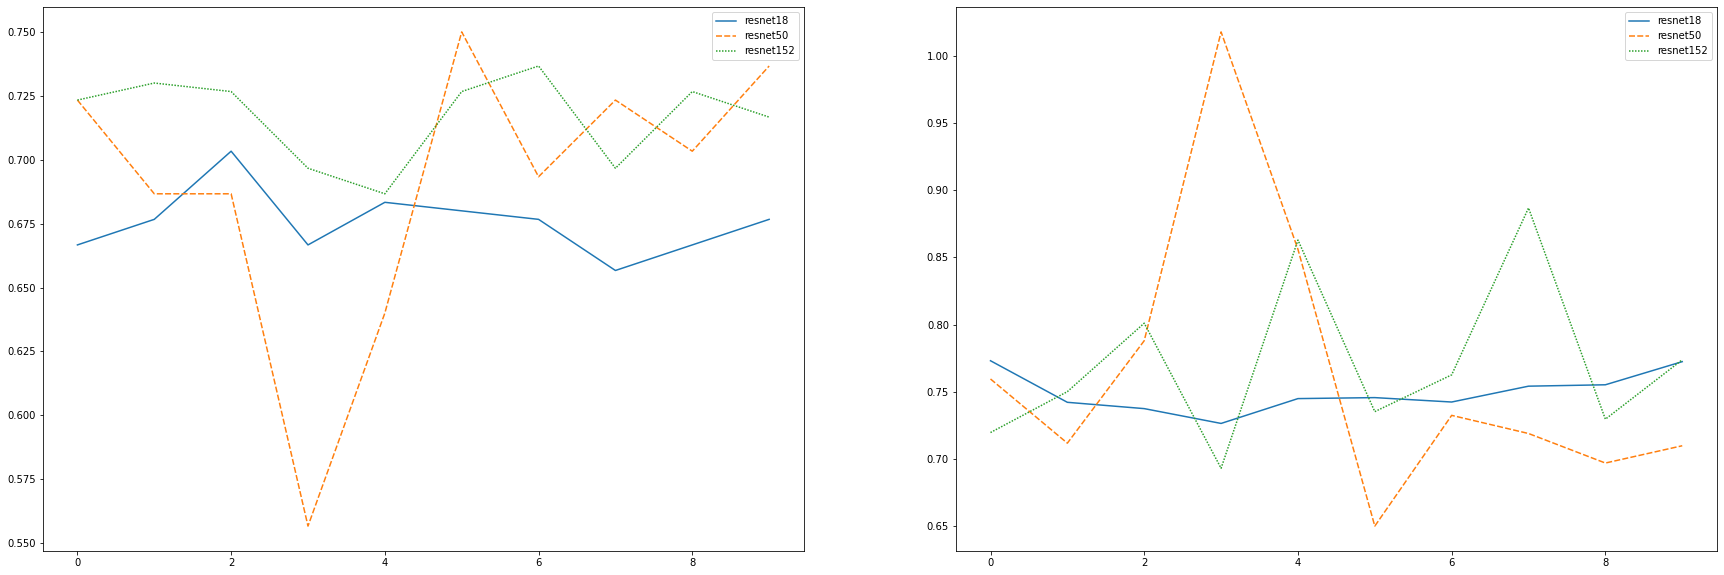

In [203]:
val_acc, val_loss = visualize_acc(val_acc_history, val_loss_history)